Importing Libraries

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Reading the Datasets

In [49]:
trader_df = pd.read_csv('historical_data.csv')
fg_df = pd.read_csv('fear_greed_index.csv')



In [21]:
trader_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [94]:
trader_df.isnull().sum()

account             0
coin                0
execution_price     0
size_tokens         0
size_usd            0
side                0
timestamp_ist       0
start_position      0
direction           0
closed_pnl          0
transaction_hash    0
order_id            0
crossed             0
fee                 0
trade_id            0
timestamp           0
date                0
dtype: int64

In [22]:
fg_df.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,01-02-2018
1,1517549400,15,Extreme Fear,02-02-2018
2,1517635800,40,Fear,03-02-2018
3,1517722200,24,Extreme Fear,04-02-2018
4,1517808600,11,Extreme Fear,05-02-2018


In [95]:
fg_df.isnull().sum()

timestamp            0
value                0
classification       0
date                 0
sentiment_numeric    0
dtype: int64

Cleaning & Preparing Data

In [50]:
trader_df.columns = trader_df.columns.str.strip().str.lower().str.replace(' ', '_')
fg_df.columns = fg_df.columns.str.strip().str.lower().str.replace(' ', '_')


In [51]:
numeric_cols = ['execution_price', 'size_tokens', 'size_usd', 'closed_pnl', 'fee']
trader_df[numeric_cols] = trader_df[numeric_cols].astype(float)

In [52]:
trader_df['timestamp_ist'] = pd.to_datetime(trader_df['timestamp_ist'], format='%d-%m-%Y %H:%M')
trader_df['date'] = trader_df['timestamp_ist'].dt.date

In [53]:
fg_df['date'] = pd.to_datetime(fg_df['date'], format='%d-%m-%Y').dt.date
sentiment_map = {'Extreme Fear': 0, 'Fear': 1, 'Neutral': 2, 'Greed': 3, 'Extreme Greed': 4}
fg_df['sentiment_numeric'] = fg_df['classification'].map(sentiment_map)

Merging Datasets

In [54]:
merged_df = trader_df.merge(fg_df[['date','value','classification','sentiment_numeric']],
                            on='date', how='left')

Trader Summary

In [55]:
trader_summary = merged_df.groupby('account').agg({
    'closed_pnl':'sum',
    'size_usd':'sum',
    'fee':'sum',
    'sentiment_numeric':'mean',
    'execution_price':'mean'
}).reset_index()

Daily Summary

In [56]:
daily_summary = merged_df.groupby('date').agg({
    'closed_pnl':'sum',
    'account':'nunique',  # number of active traders
    'size_usd':'sum',
    'sentiment_numeric':'mean'
}).reset_index()


In [57]:
trade_type_count = merged_df.groupby(['account','side']).size().unstack(fill_value=0).reset_index()

Visualizing Sentiment Counts

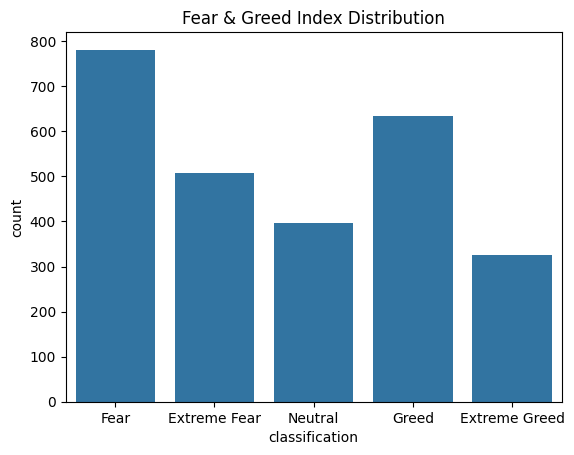

In [58]:
sns.countplot(data=fg_df, x='classification')
plt.title('Fear & Greed Index Distribution')
plt.show()

In [74]:
# Using value_counts()
fg_counts = fg_df['classification'].value_counts()
print(fg_counts)


classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64


Trader Profit vs Sentiment

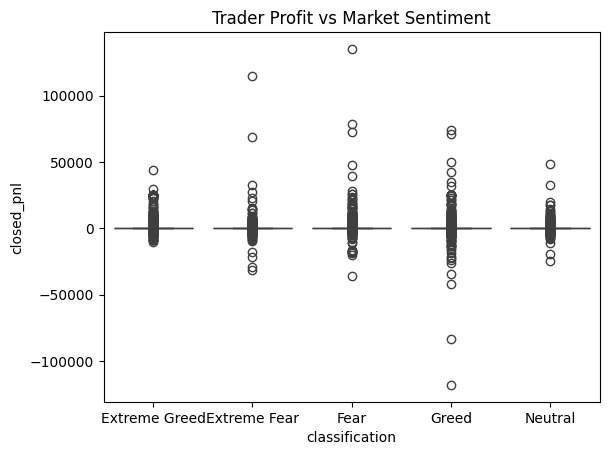

In [59]:
box_df = merged_df.dropna(subset=['classification','closed_pnl'])
sns.boxplot(data=box_df, x='classification', y='closed_pnl')
plt.title('Trader Profit vs Market Sentiment')
plt.show()

In [77]:
counts = box_df['classification'].value_counts()
print(counts)


classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64


Daily Trade Volume vs Market Sentiment

In [83]:
sentiment_labels = {0: 'Extreme Fear', 1: 'Fear', 2: 'Neutral', 3: 'Greed', 4: 'Extreme Greed'}
daily_summary['sentiment_label'] = daily_summary['sentiment_numeric'].round().map(sentiment_labels)


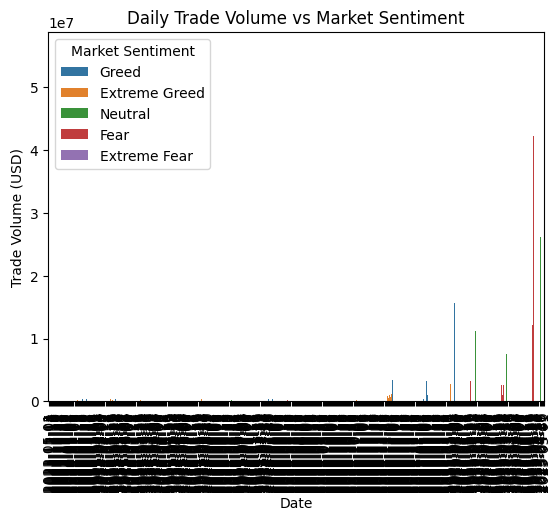

In [84]:
sns.barplot(data=daily_summary, x='date', y='size_usd', hue='sentiment_label')
plt.xticks(rotation=90)
plt.title('Daily Trade Volume vs Market Sentiment')
plt.ylabel('Trade Volume (USD)')
plt.xlabel('Date')
plt.legend(title='Market Sentiment')
plt.show()


In [82]:
# Group by date and sentiment to get total trade volume per sentiment per day
daily_values = merged_df.groupby(['date', 'sentiment_numeric'])['size_usd'].sum().reset_index()

daily_values


,date,sentiment_numeric,size_usd
0,2023-05-01,3.0,477.00
1,2023-12-05,4.0,50005.83
2,2023-12-14,3.0,113203.35
3,2023-12-15,3.0,10609.95
4,2023-12-16,3.0,15348.77
...,...,...,...
474,2025-04-27,3.0,487537.69
475,2025-04-28,2.0,26124921.49
476,2025-04-29,3.0,34089511.66
477,2025-04-30,3.0,12693878.85


In [61]:
performance = merged_df.groupby('classification')['closed_pnl'].mean().reset_index()
print(performance)

  classification  closed_pnl
0   Extreme Fear   34.537862
1  Extreme Greed   67.892861
2           Fear   54.290400
3          Greed   42.743559
4        Neutral   34.307718


In [62]:
merged_df.isna().sum()


account              0
coin                 0
execution_price      0
size_tokens          0
size_usd             0
side                 0
timestamp_ist        0
start_position       0
direction            0
closed_pnl           0
transaction_hash     0
order_id             0
crossed              0
fee                  0
trade_id             0
timestamp            0
date                 0
value                6
classification       6
sentiment_numeric    6
dtype: int64

In [63]:
trader_summary.describe()


,closed_pnl,size_usd,fee,sentiment_numeric,execution_price
count,3.200000e+01,3.200000e+01,32.000000,32.000000,32.000000
mean,3.217800e+05,3.722461e+07,7683.053768,2.084016,13447.480768
std,4.948276e+05,7.706987e+07,15287.906732,0.758743,21032.848168
min,-1.676211e+05,7.280575e+05,147.074763,0.649775,4.961415
25%,4.689324e+04,4.069408e+06,697.437514,1.611289,263.913987
50%,1.176551e+05,1.173684e+07,2441.607287,2.143185,5610.992195
75%,4.063941e+05,3.529832e+07,7560.482327,2.727887,17164.955360
max,2.143383e+06,4.208766e+08,76424.642892,3.357314,81452.298506


Daily Trade Volume Over Time

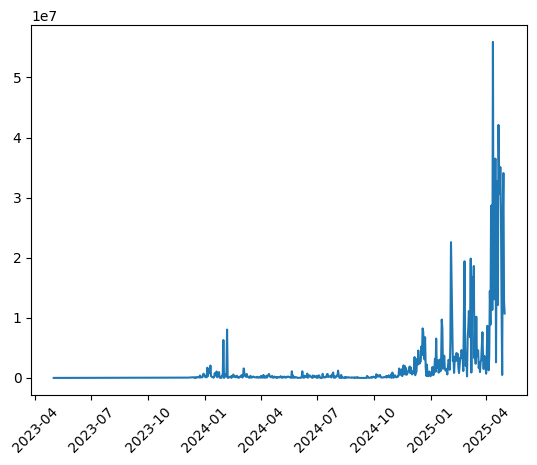

In [65]:
plt.plot(daily_summary['date'], daily_summary['size_usd'])
plt.xticks(rotation=45)
plt.show()

In [86]:
# List of size_usd values
size_usd_values = daily_summary['size_usd'].tolist()
print(size_usd_values)


[477.0, 50005.83, 113203.35, 10609.95, 15348.77, 116278.02, 31164.179999999997, 91602.41, 141636.79, 125233.97, 88874.28, 78438.25, 402954.94, 59948.51, 171411.06, 100117.25, 569559.72, 702550.21, 264239.52999999997, 121348.74, 394499.36, 99792.54000000001, 1703942.66, 298521.4, 1048850.06, 1522452.43, 870051.97, 2057479.48, 305314.1, 200082.27, 50636.1, 116427.33, 800831.03, 424631.52999999997, 428428.97, 1070090.51, 103129.74, 337878.99, 414518.93000000005, 965084.59, 66566.13, 11773.21, 18109.03, 414208.18, 401011.38, 6305647.13, 2008.18, 474278.43, 603820.0, 203187.53, 770198.26, 8047153.41, 6758.73, 26051.12, 212311.82, 227247.69999999998, 1999.99, 320839.88, 185188.04, 564896.51, 406118.07, 157048.17, 286377.2, 119419.72, 108047.51999999999, 373033.87, 111106.14, 4480.13, 192187.14, 209362.3, 171107.13, 395666.73, 472974.7, 63197.56, 390745.68, 1577996.87, 841810.32, 327218.02, 183583.18, 658178.75, 219973.85, 176519.44999999998, 103040.85, 6000.799999999999, 205933.18, 351894.41

In [85]:
# Values for the line plot
daily_values = daily_summary[['date', 'size_usd']]
print(daily_values)


          date     size_usd
0   2023-05-01       477.00
1   2023-12-05     50005.83
2   2023-12-14    113203.35
3   2023-12-15     10609.95
4   2023-12-16     15348.77
..         ...          ...
475 2025-04-27    487537.69
476 2025-04-28  26124921.49
477 2025-04-29  34089511.66
478 2025-04-30  12693878.85
479 2025-05-01  10720240.52

[480 rows x 2 columns]


In [66]:
trade_type_count.head()


side,account,BUY,SELL
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1711,2107
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,3055,4225
2,0x271b280974205ca63b716753467d5a371de622ab,1566,2243
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,6699,6612
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,1179,2060


In [67]:
merged_df[['closed_pnl','sentiment_numeric','execution_price','size_usd']].corr()


,closed_pnl,sentiment_numeric,execution_price,size_usd
closed_pnl,1.000000,0.005970,-0.006505,0.123589
sentiment_numeric,0.005970,1.000000,-0.038316,-0.031912
execution_price,-0.006505,-0.038316,1.000000,0.189855
size_usd,0.123589,-0.031912,0.189855,1.000000


Fear & Greed Index Distribution

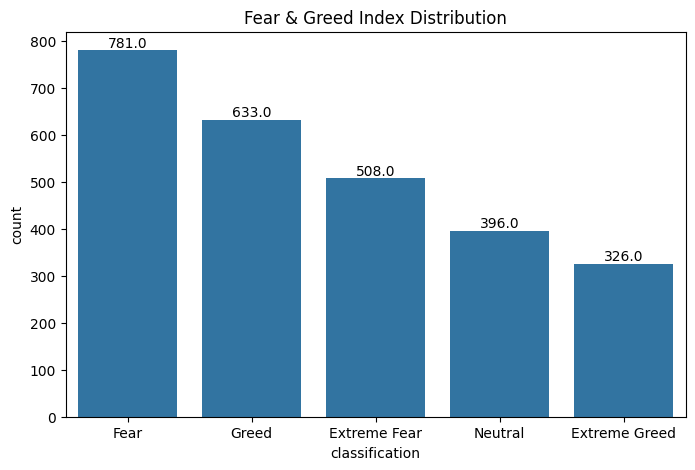

In [70]:
plt.figure(figsize=(8,5))
ax = sns.countplot(data=fg_df, x='classification', order=fg_df['classification'].value_counts().index)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=10)
plt.title('Fear & Greed Index Distribution')
plt.show()


Trader Profit vs Market Sentiment

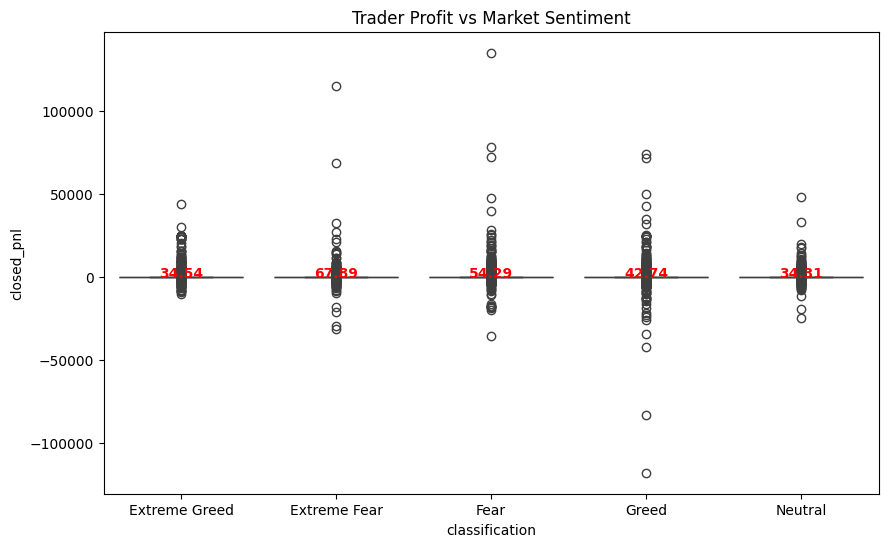

In [71]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(data=merged_df, x='classification', y='closed_pnl')

# Add mean values on top
group_means = merged_df.groupby('classification')['closed_pnl'].mean()
for i, mean in enumerate(group_means):
    ax.text(i, mean, f'{mean:.2f}', horizontalalignment='center', color='red', weight='bold')

plt.title('Trader Profit vs Market Sentiment')
plt.show()


Daily Trade Volume vs Market Sentiment

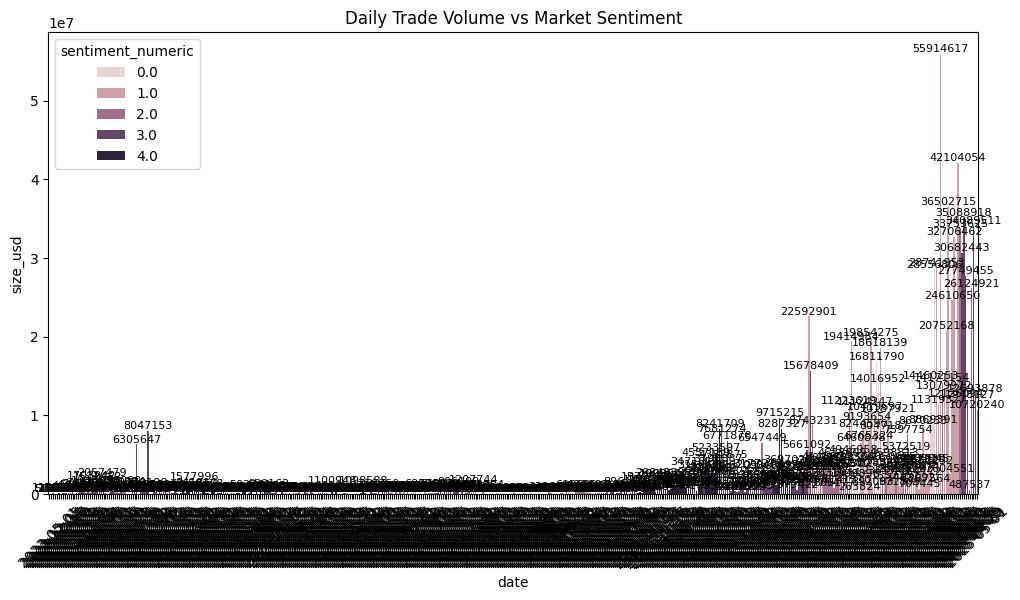

In [72]:
daily_summary['date'] = pd.to_datetime(daily_summary['date'])
plt.figure(figsize=(12,6))
ax = sns.barplot(data=daily_summary, x='date', y='size_usd', hue='sentiment_numeric', dodge=False)

# Annotate each bar with its value
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=8)

plt.xticks(rotation=45)
plt.title('Daily Trade Volume vs Market Sentiment')
plt.show()


In [89]:
# Ensure 'date' is datetime
daily_summary['date'] = pd.to_datetime(daily_summary['date'])

# Get only the 'size_usd' values as a list
daily_trade_values = daily_summary['size_usd'].tolist()

print(daily_trade_values)


[477.0, 50005.83, 113203.35, 10609.95, 15348.77, 116278.02, 31164.179999999997, 91602.41, 141636.79, 125233.97, 88874.28, 78438.25, 402954.94, 59948.51, 171411.06, 100117.25, 569559.72, 702550.21, 264239.52999999997, 121348.74, 394499.36, 99792.54000000001, 1703942.66, 298521.4, 1048850.06, 1522452.43, 870051.97, 2057479.48, 305314.1, 200082.27, 50636.1, 116427.33, 800831.03, 424631.52999999997, 428428.97, 1070090.51, 103129.74, 337878.99, 414518.93000000005, 965084.59, 66566.13, 11773.21, 18109.03, 414208.18, 401011.38, 6305647.13, 2008.18, 474278.43, 603820.0, 203187.53, 770198.26, 8047153.41, 6758.73, 26051.12, 212311.82, 227247.69999999998, 1999.99, 320839.88, 185188.04, 564896.51, 406118.07, 157048.17, 286377.2, 119419.72, 108047.51999999999, 373033.87, 111106.14, 4480.13, 192187.14, 209362.3, 171107.13, 395666.73, 472974.7, 63197.56, 390745.68, 1577996.87, 841810.32, 327218.02, 183583.18, 658178.75, 219973.85, 176519.44999999998, 103040.85, 6000.799999999999, 205933.18, 351894.41

Trader Profit vs Sentiment (Numeric)

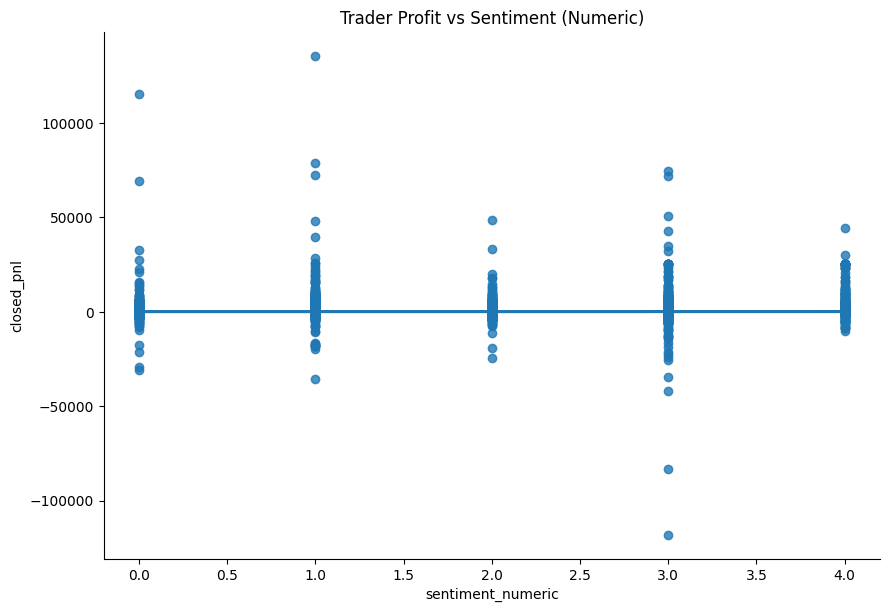

In [73]:
sns.lmplot(data=merged_df, x='sentiment_numeric', y='closed_pnl', height=6, aspect=1.5)
plt.title('Trader Profit vs Sentiment (Numeric)')
plt.show()
